In [ ]:
import polars as pl
import datetime

# --- CONFIG ---
DATA_DIR = "data"
OUTPUT_FILE = DATA_DIR/"supervised_model_dataset.csv"


def load_and_process():
    print("🚀 Starting Data Pipeline...")

    # 1. Load Data
    print("🔹 Loading raw files...")
    df_clusters = pl.read_csv(f"{DATA_DIR}/clustered_customer.csv")
    df_orders = pl.read_csv(f"{DATA_DIR}/olist_orders_dataset.csv")
    df_customers = pl.read_csv(f"{DATA_DIR}/olist_customers_dataset.csv")
    df_payments = pl.read_csv(f"{DATA_DIR}/olist_order_payments_dataset.csv")
    df_reviews = pl.read_csv(f"{DATA_DIR}/olist_order_reviews_dataset.csv", ignore_errors=True)
    df_items = pl.read_csv(f"{DATA_DIR}/olist_order_items_dataset.csv")

    # 2. Process ORDERS (The Backbone)
    # Logic: Only 'delivered'. Cast dates. Map customer_id to customer_unique_id
    print("🔹 Processing Orders...")
    
    # First, map customer_id to customer_unique_id
    df_customer_mapping = df_customers.select(["customer_id", "customer_unique_id"])
    
    df_orders_clean = (
        df_orders.filter(pl.col("order_status") == "delivered")
        .with_columns([
            pl.col("order_purchase_timestamp").str.to_datetime(),
            pl.col("order_estimated_delivery_date").str.to_datetime(),
            pl.col("order_delivered_customer_date").str.to_datetime()
        ])
        .select([
            "order_id", 
            "customer_id", 
            "order_purchase_timestamp",
            "order_estimated_delivery_date",
            "order_delivered_customer_date"
        ])
        # Join with customer mapping to get customer_unique_id
        .join(df_customer_mapping, on="customer_id", how="left")
    )
    
    # Calculate estimated delivery time (in days)
    df_orders_clean = df_orders_clean.with_columns(
        (pl.col("order_estimated_delivery_date") - pl.col("order_purchase_timestamp"))
        .dt.total_days()
        .alias("estimated_delivery_days")
    )
    
    # Define "Now" as the day after the last purchase in the dataset
    max_date = df_orders_clean["order_purchase_timestamp"].max()
    anchor_date = max_date + datetime.timedelta(days=1)
    print(f"   Note: Anchor Date for Recency set to {anchor_date}")

    # 3. Process ITEMS (Product & Freight Info)
    print("🔹 Processing Order Items...")
    df_items_agg = (
        df_items
        .join(df_orders_clean.select(["order_id"]), on="order_id", how="inner")
        .group_by("order_id")
        .agg([
            pl.count("order_item_id").alias("num_items"),
            pl.col("freight_value").mean().alias("freight_value"),
            pl.col("price").sum().alias("total_price")
        ])
    )

    # 4. Process PAYMENTS
    print("🔹 Processing Payments...")
    df_payments_agg = (
        df_payments
        .join(df_orders_clean.select(["order_id"]), on="order_id", how="inner")
        .group_by("order_id")
        .agg([
            pl.col("payment_installments").mean().alias("avg_installments_order"),
            pl.col("payment_value").mean().alias("avg_payment_value_per_payment"),
            (pl.col("payment_type") == "credit_card").mean().alias("credit_card_ratio_order")
        ])
    )

    # 5. Get Product Categories per Customer (using customer_unique_id)
    print("🔹 Processing Product Categories...")
    df_products = pl.read_csv(f"{DATA_DIR}/olist_products_dataset.csv")
    df_categories = (
        df_items
        .join(df_orders_clean.select(["order_id", "customer_unique_id"]), on="order_id", how="inner")
        .join(df_products.select(["product_id", "product_category_name"]), on="product_id", how="left")
        .group_by("customer_unique_id")
        .agg([
            pl.col("product_category_name").n_unique().alias("num_unique_product_category")
        ])
    )

    # 6. Merge Order-Level Features
    print("🔹 Merging order-level data...")
    df_order_features = (
        df_orders_clean
        .join(df_items_agg, on="order_id", how="left")
        .join(df_payments_agg, on="order_id", how="left")
    )

    # Calculate freight_to_price_ratio
    df_order_features = df_order_features.with_columns(
        (pl.col("freight_value") / pl.when(pl.col("total_price") > 0)
         .then(pl.col("total_price"))
         .otherwise(1)).alias("freight_to_price_ratio")
    )

    # 7. Aggregate to Customer Level (using customer_unique_id)
    print("🔹 Aggregating to customer_unique_id level...")
    df_customer_features = (
        df_order_features
        .group_by("customer_unique_id")
        .agg([
            pl.col("num_items").mean().alias("avg_item_per_order"),
            pl.col("freight_value").mean().alias("avg_freight_value"),
            pl.col("freight_to_price_ratio").mean().alias("freight_to_price_ratio"),
            pl.col("avg_installments_order").mean().alias("avg_installments"),
            pl.col("credit_card_ratio_order").mean().alias("share_credit_card_payment"),
            pl.col("avg_payment_value_per_payment").mean().alias("avg_payment_value_per_payment"),
            pl.col("estimated_delivery_days").mean().alias("avg_estimated_delivery_time")
        ])
    )

    # 8. Join with categories and clusters
    print("🔹 Joining with categories and clusters...")
    
    # Rename Cluster_Label to cluster_id in clusters dataframe
    df_clusters_renamed = df_clusters.select([
        pl.col("customer_unique_id"),
        pl.col("Cluster_Label").alias("cluster_id")
    ])
    
    # Join with categories and clusters using customer_unique_id
    df_final = (
        df_customer_features
        .join(df_categories, on="customer_unique_id", how="left")
        .join(df_clusters_renamed, on="customer_unique_id", how="left")
        .fill_null(0)  # Fill missing values with 0
        .select([
            "customer_unique_id",
            "avg_item_per_order",
            "avg_freight_value",
            "freight_to_price_ratio",
            "avg_installments",
            "share_credit_card_payment",
            "avg_payment_value_per_payment",
            "avg_estimated_delivery_time",
            "num_unique_product_category",
            "cluster_id"
        ])
    )

    # 9. Save Output
    print(f"🔹 Saving to {OUTPUT_FILE}...")
    df_final.write_csv(OUTPUT_FILE)
    
    print(f"✅ Pipeline Complete! Dataset shape: {df_final.shape}")
    print(f"   Columns: {df_final.columns}")
    print(f"   Unique customers: {df_final.select('customer_unique_id').n_unique()}")
    return df_final


# Run the pipeline
if __name__ == "__main__":
    df_result = load_and_process()
    print("\n📊 Sample of the dataset:")
    print(df_result.head())


🚀 Starting Data Pipeline...
🔹 Loading raw files...
🔹 Processing Orders...
   Note: Anchor Date for Recency set to 2018-08-30 15:00:37
🔹 Processing Order Items...
🔹 Processing Payments...
🔹 Processing Product Categories...
🔹 Merging order-level data...
🔹 Aggregating to customer_unique_id level...
🔹 Joining with categories and clusters...
🔹 Saving to D:/PythonCode/Group 1 - Materials & resources-20260121T053533Z-1-001/Group 1 - Materials & resources/data/supervised_model_dataset.csv...
✅ Pipeline Complete! Dataset shape: (93358, 10)
   Columns: ['customer_unique_id', 'avg_item_per_order', 'avg_freight_value', 'freight_to_price_ratio', 'avg_installments', 'share_credit_card_payment', 'avg_payment_value_per_payment', 'avg_estimated_delivery_time', 'num_unique_product_category', 'cluster_id']
   Unique customers: 93358

📊 Sample of the dataset:
shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ customer_ ┆ avg_item_ ┆ avg_fr

📊 DATA VALIDATION & EXPLORATORY DATA ANALYSIS

1️⃣ BASIC INFORMATION
   Shape: (93358, 10)
   Columns: ['customer_unique_id', 'avg_item_per_order', 'avg_freight_value', 'freight_to_price_ratio', 'avg_installments', 'share_credit_card_payment', 'avg_payment_value_per_payment', 'avg_estimated_delivery_time', 'num_unique_product_category', 'cluster_id']

   Data Types:
[String, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64]

2️⃣ MISSING VALUES CHECK
shape: (1, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ customer_ ┆ avg_item_ ┆ avg_freig ┆ freight_t ┆ … ┆ avg_payme ┆ avg_estim ┆ num_uniqu ┆ cluster_ │
│ unique_id ┆ per_order ┆ ht_value  ┆ o_price_r ┆   ┆ nt_value_ ┆ ated_deli ┆ e_product ┆ id       │
│ ---       ┆ ---       ┆ ---       ┆ atio      ┆   ┆ per_payme ┆ very_time ┆ _category ┆ ---      │
│ u32       ┆ u32       ┆ u32       ┆ ---       ┆   ┆ nt        ┆ ---       ┆ ---       ┆ u32      │

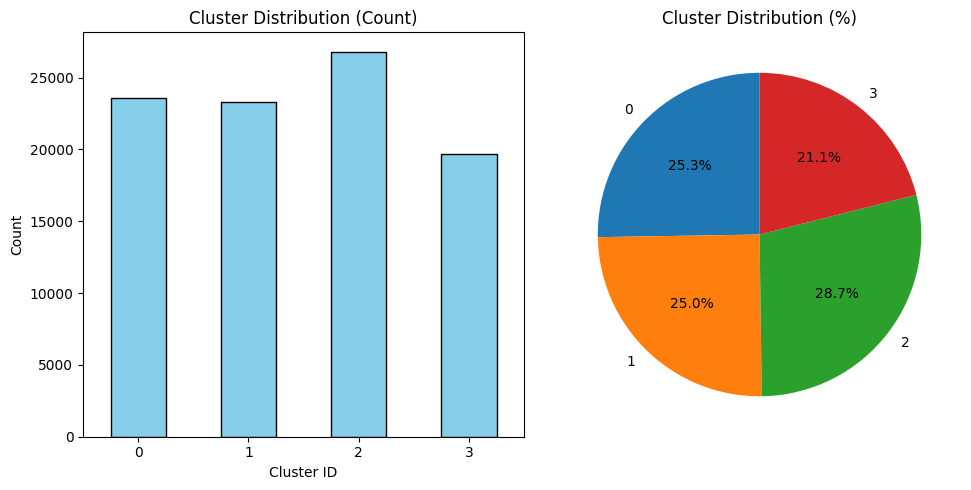


   Imbalance Ratio: 1.36x

4️⃣ FEATURE STATISTICS
shape: (9, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ customer_ ┆ avg_item_ ┆ avg_freig ┆ … ┆ avg_payme ┆ avg_estim ┆ num_uniqu ┆ cluster_ │
│ ---       ┆ unique_id ┆ per_order ┆ ht_value  ┆   ┆ nt_value_ ┆ ated_deli ┆ e_product ┆ id       │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ per_payme ┆ very_time ┆ _category ┆ ---      │
│           ┆ str       ┆ f64       ┆ f64       ┆   ┆ nt        ┆ ---       ┆ ---       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ f64       ┆ f64       ┆          │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 93358     ┆ 93358.0   ┆ 93358.0   ┆ … ┆ 93358.0   ┆ 93358.0   ┆ 93358.0   ┆ 93358.0  │
│ null_coun ┆ 0         ┆

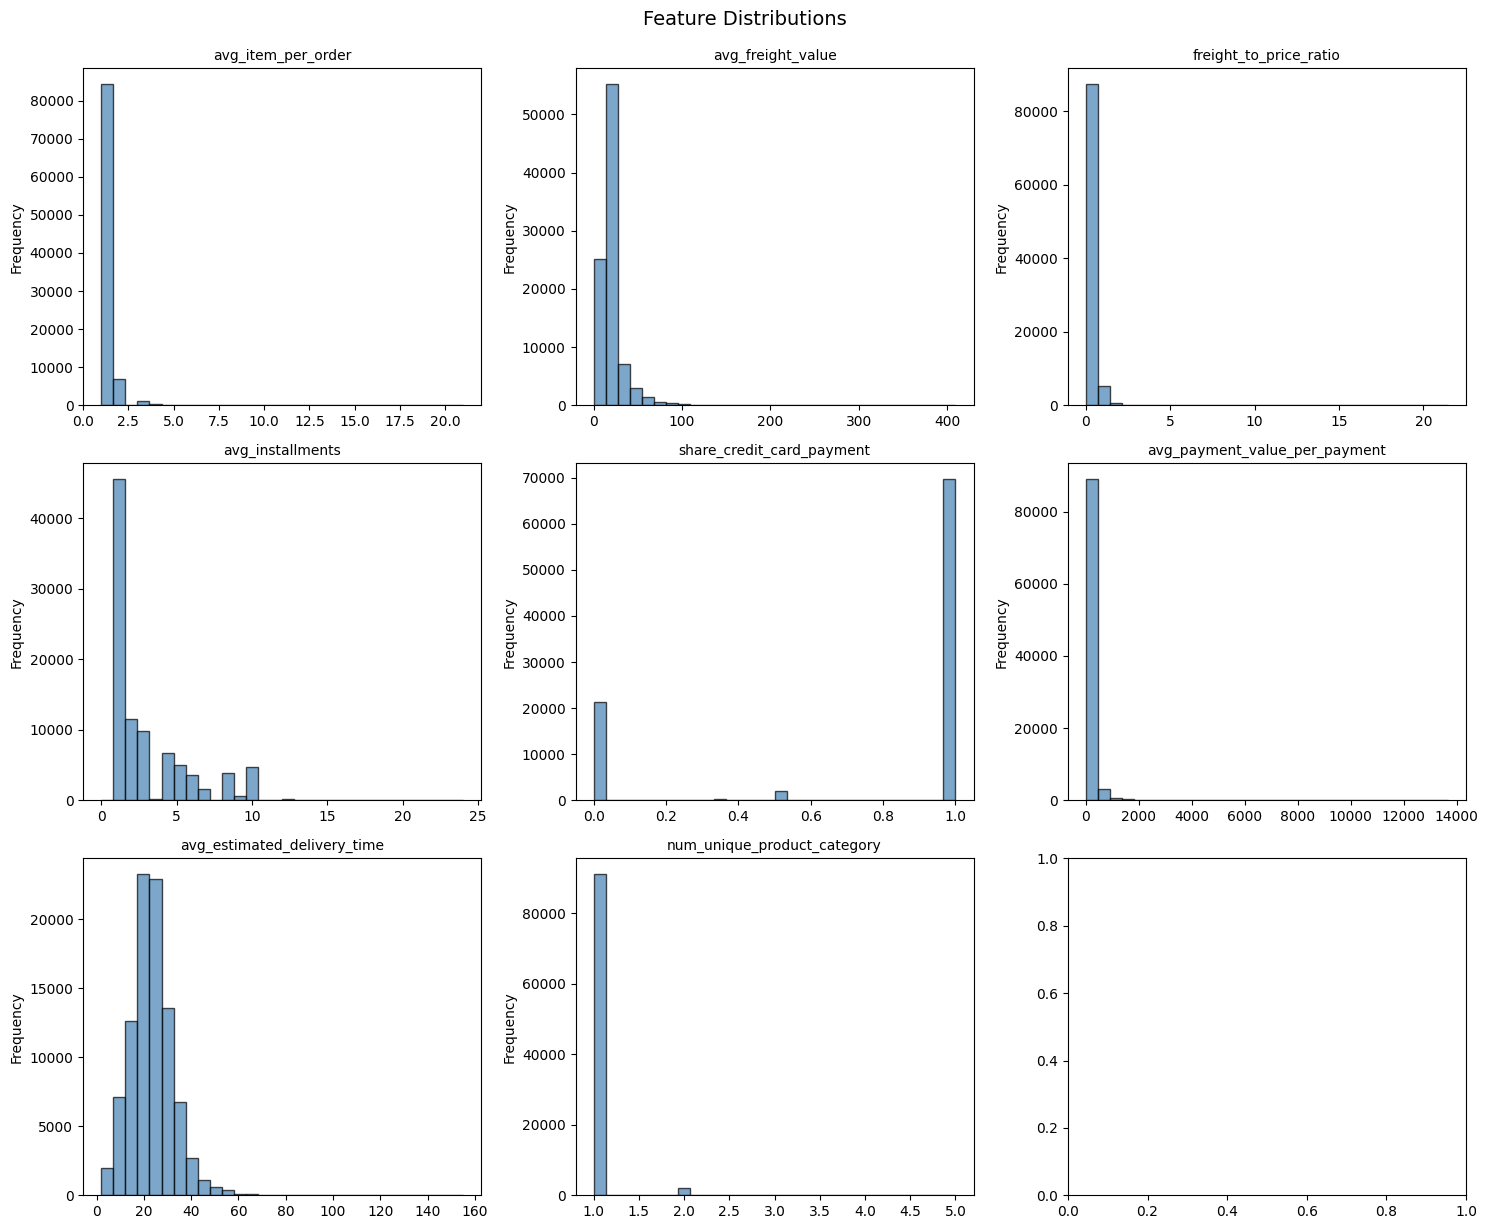


7️⃣ CORRELATION ANALYSIS

   High Correlations (|r| > 0.7):
   ✅ No high multicollinearity detected


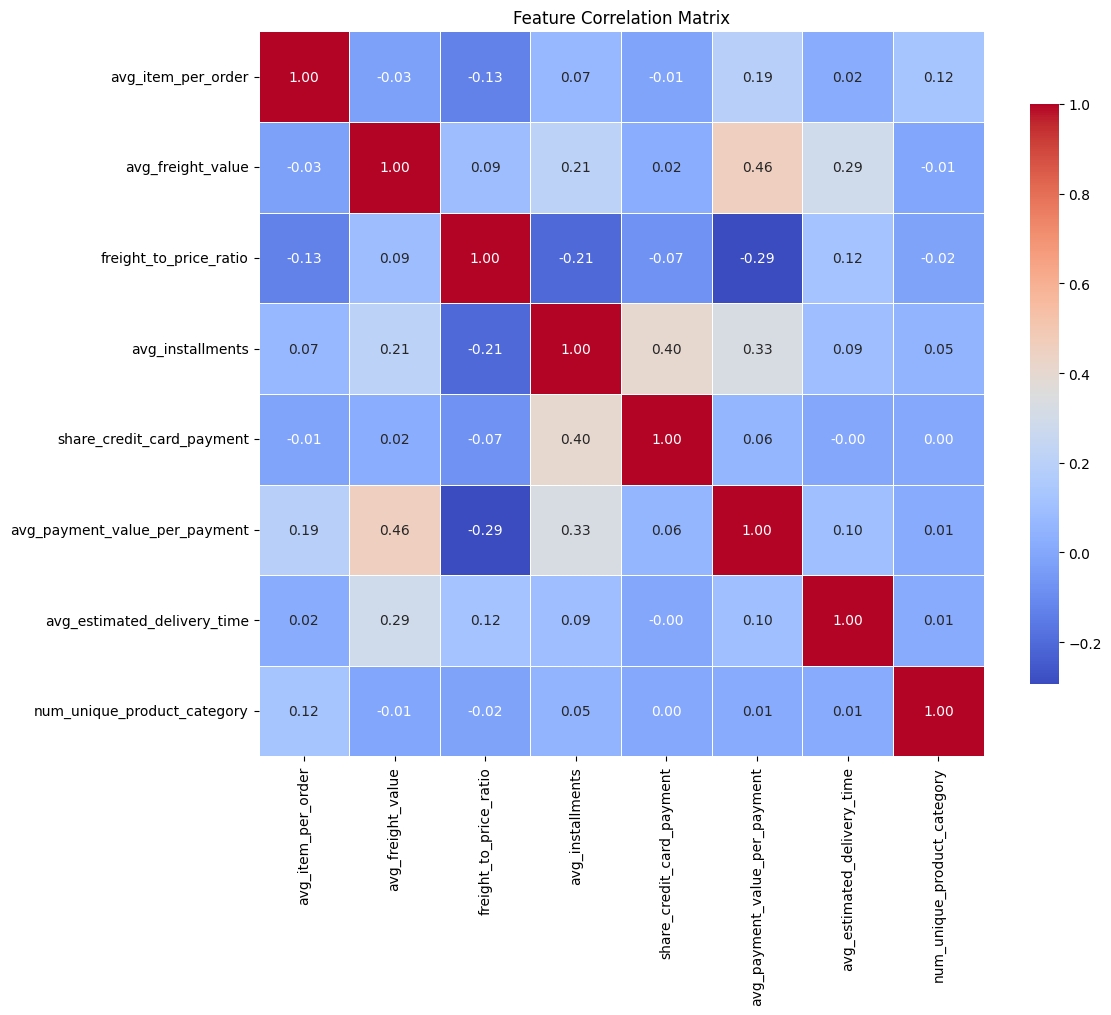


8️⃣ FEATURE vs TARGET (Distribution by Cluster)


C:\Users\Huy\AppData\Local\Temp\ipykernel_24860\87835815.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pd, x='cluster_id', y=col, ax=axes[idx],
C:\Users\Huy\AppData\Local\Temp\ipykernel_24860\87835815.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pd, x='cluster_id', y=col, ax=axes[idx],
C:\Users\Huy\AppData\Local\Temp\ipykernel_24860\87835815.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pd, x='cluster_id', y=col, ax=axes[idx],
C:\Users\Huy\AppData\Local\Temp\ipykernel_24860\87835815.p

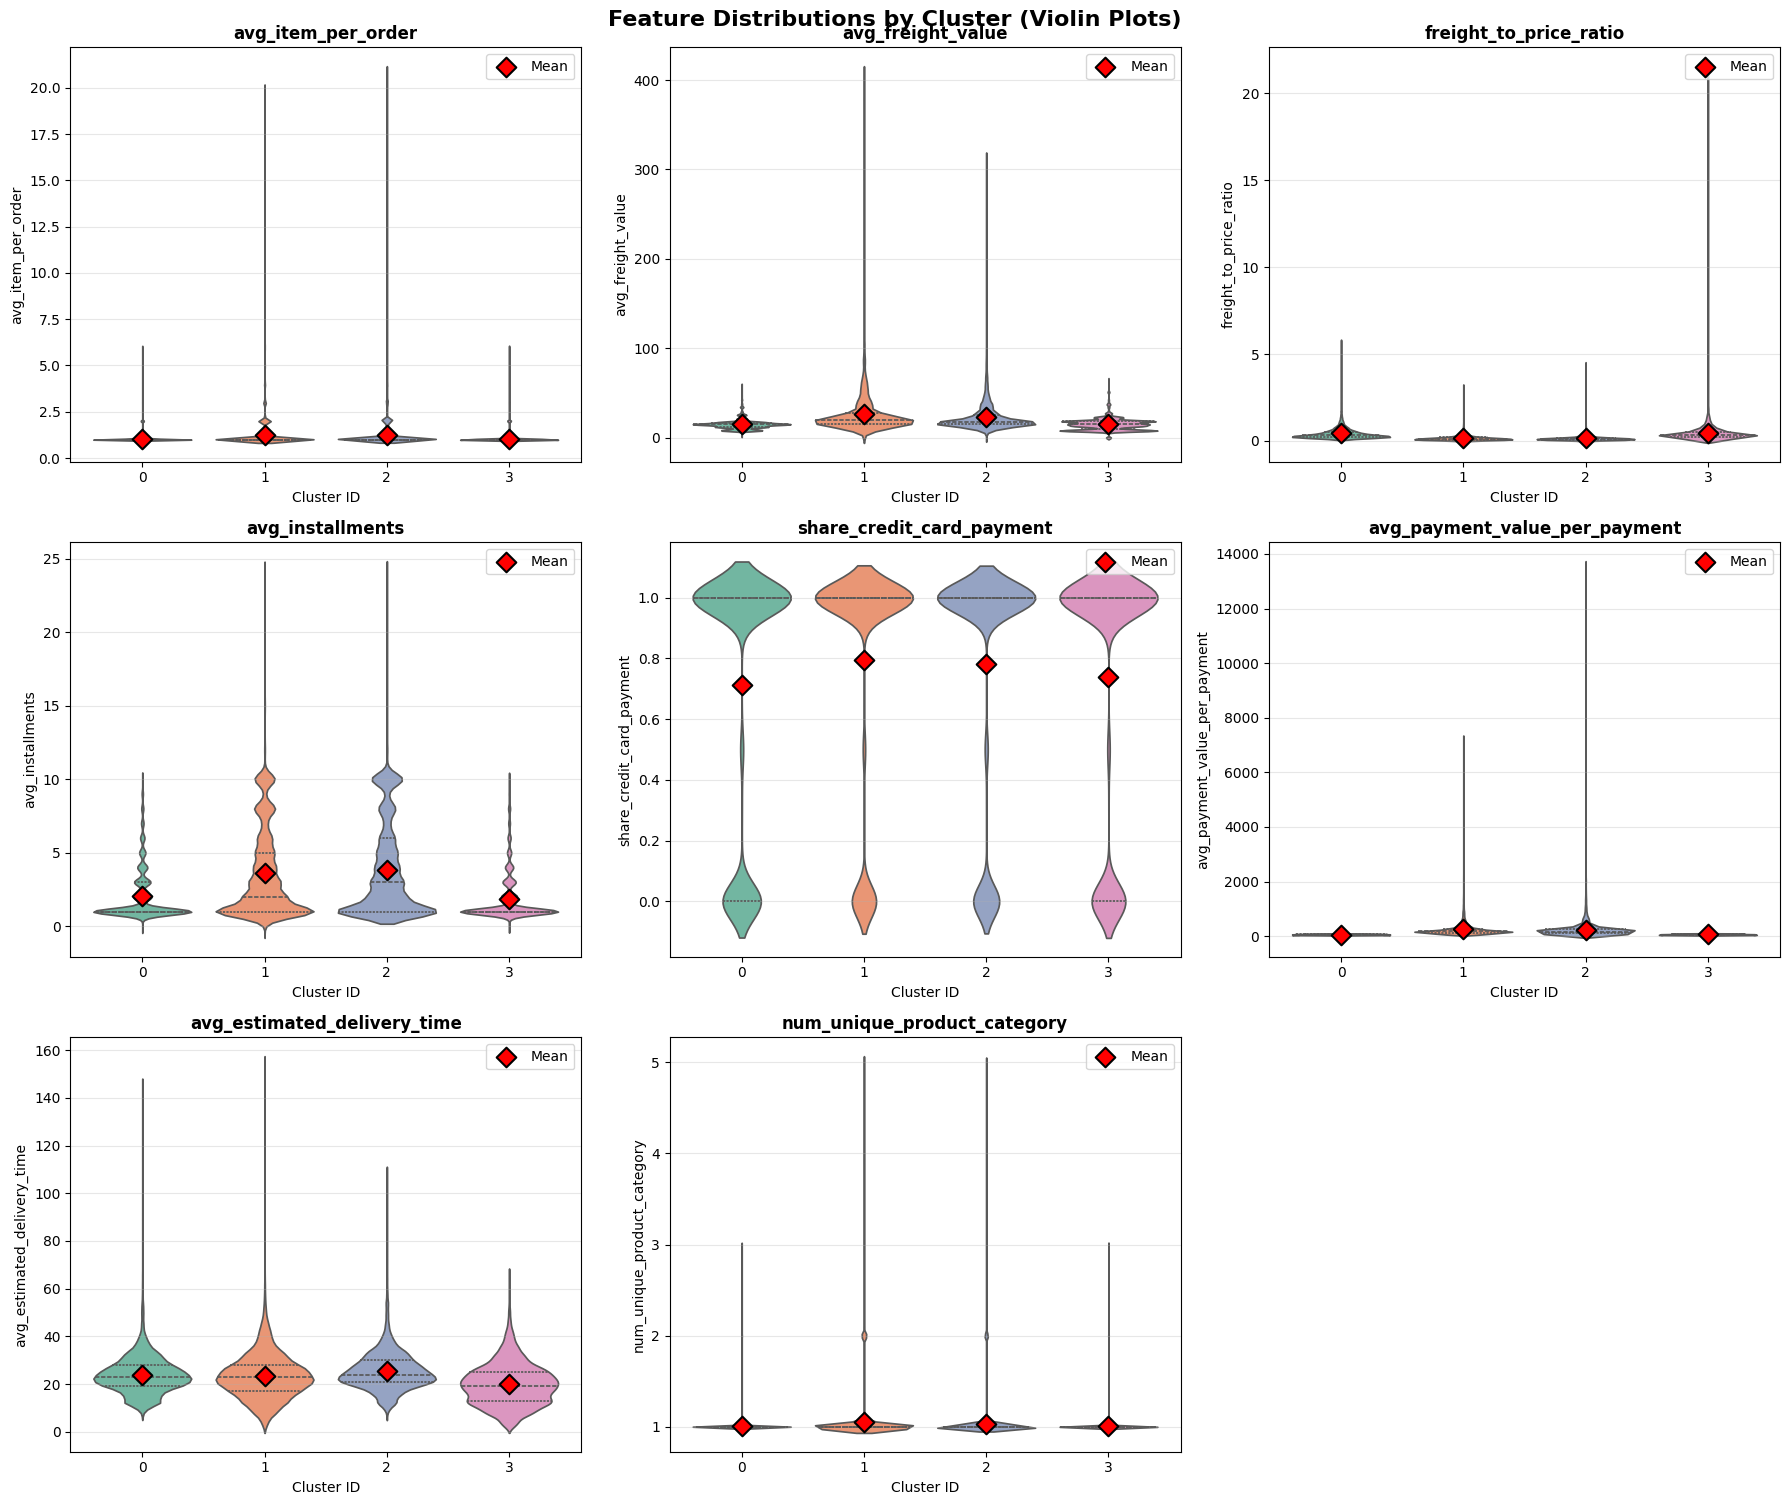


9️⃣ DATA QUALITY CHECKS
   Duplicate rows: 5476
   ✅ No zero variance features

   Value Ranges:
   avg_item_per_order: [1.00, 21.00]
   avg_freight_value: [0.00, 409.68]
   freight_to_price_ratio: [0.00, 21.45]
   avg_installments: [0.00, 24.00]
   share_credit_card_payment: [0.00, 1.00]
   avg_payment_value_per_payment: [0.00, 13664.08]
   avg_estimated_delivery_time: [2.00, 155.00]
   num_unique_product_category: [1.00, 5.00]


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pl.read_csv(OUTPUT_FILE)
print("=" * 60)
print("📊 DATA VALIDATION & EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# ============================================
# 1. BASIC INFO
# ============================================
print("\n1️⃣ BASIC INFORMATION")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns}")
print(f"\n   Data Types:")
print(df.dtypes)

# ============================================
# 2. MISSING VALUES
# ============================================
print("\n2️⃣ MISSING VALUES CHECK")
null_counts = df.null_count()
print(null_counts)

if null_counts.select(pl.all().sum()).row(0)[0] > 0:
    print("⚠️  WARNING: Missing values detected!")
else:
    print("✅ No missing values")

# ============================================
# 3. TARGET VARIABLE (cluster_id)
# ============================================
print("\n3️⃣ TARGET VARIABLE DISTRIBUTION")
target_dist = df.group_by("cluster_id").len().sort("cluster_id")
print(target_dist)

# Check class imbalance
df_pd = df.to_pandas()
cluster_counts = df_pd['cluster_id'].value_counts().sort_index()
print(f"\n   Class Distribution:")
for cluster, count in cluster_counts.items():
    percentage = (count / len(df_pd)) * 100
    print(f"   Cluster {int(cluster)}: {count} ({percentage:.2f}%)")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Distribution (Count)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Cluster Distribution (%)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Check if imbalanced
min_class = cluster_counts.min()
max_class = cluster_counts.max()
imbalance_ratio = max_class / min_class
print(f"\n   Imbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 3:
    print("   ⚠️  WARNING: Significant class imbalance detected!")
    print("   → Consider: SMOTE, class_weight, or stratified sampling")

# ============================================
# 4. FEATURE STATISTICS
# ============================================
print("\n4️⃣ FEATURE STATISTICS")
print(df.describe())

# ============================================
# 5. OUTLIERS DETECTION
# ============================================
print("\n5️⃣ OUTLIERS DETECTION (IQR Method)")
feature_cols = [col for col in df.columns if col not in ['customer_id', 'customer_unique_id', 'cluster_id']]

outlier_summary = {}
for col in feature_cols:
    Q1 = df_pd[col].quantile(0.25)
    Q3 = df_pd[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_pd[(df_pd[col] < lower_bound) | (df_pd[col] > upper_bound)]
    outlier_summary[col] = len(outliers)
    
outlier_df = pd.DataFrame(outlier_summary.items(), columns=['Feature', 'Outlier Count'])
outlier_df['Outlier %'] = (outlier_df['Outlier Count'] / len(df_pd)) * 100
print(outlier_df.sort_values('Outlier Count', ascending=False))

# ============================================
# 6. FEATURE DISTRIBUTIONS
# ============================================
print("\n6️⃣ FEATURE DISTRIBUTIONS")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    if idx < len(axes):
        axes[idx].hist(df_pd[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(col, fontsize=10)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Feature Distributions', fontsize=14, y=1.02)
plt.show()

# ============================================
# 7. CORRELATION MATRIX
# ============================================
print("\n7️⃣ CORRELATION ANALYSIS")
corr_matrix = df_pd[feature_cols].corr()
print("\n   High Correlations (|r| > 0.7):")
high_corr = np.where(np.abs(corr_matrix) > 0.7)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                   for x, y in zip(*high_corr) if x != y and x < y]

if high_corr_pairs:
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"   {feat1} ↔ {feat2}: {corr_val:.3f}")
else:
    print("   ✅ No high multicollinearity detected")

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# ============================================
# 8. FEATURE vs TARGET (Violin Plots + Swarm Plots)
# ============================================
print("\n8️⃣ FEATURE vs TARGET (Distribution by Cluster)")

n_features = len(feature_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    # Violin plot shows distribution shape
    sns.violinplot(data=df_pd, x='cluster_id', y=col, ax=axes[idx], 
                   palette='Set2', inner='quartile')
    
    # Add mean markers
    cluster_means = df_pd.groupby('cluster_id')[col].mean()
    axes[idx].scatter(range(len(cluster_means)), cluster_means, 
                     color='red', s=100, zorder=3, marker='D', 
                     label='Mean', edgecolors='black', linewidths=1.5)
    
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster ID', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].legend(loc='upper right')
    axes[idx].grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Feature Distributions by Cluster (Violin Plots)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.show()

# ============================================
# 9. DATA QUALITY CHECKS
# ============================================
print("\n9️⃣ DATA QUALITY CHECKS")

# Check for duplicates
duplicates = df_pd.duplicated(subset=feature_cols).sum()
print(f"   Duplicate rows: {duplicates}")

# Check for zero variance
zero_var = df_pd[feature_cols].var() == 0
if zero_var.any():
    print(f"   ⚠️  Zero variance features: {list(zero_var[zero_var].index)}")
else:
    print("   ✅ No zero variance features")

# Check value ranges
print("\n   Value Ranges:")
for col in feature_cols:
    print(f"   {col}: [{df_pd[col].min():.2f}, {df_pd[col].max():.2f}]")

- Tồn tại 5475 rows có dữ liệu giống nhau nhưng khác customer_unique_id. Điều này chứng tỏ tồn tại 1 số lượng nhỏ khách hàng có hành vi mua hàng "gần như giống nhau".